In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
bert_raw_neighbours = pd.read_csv('results/bert_raw_neighbours.csv',index_col = 0)
count_word_raw = pd.read_csv('results/count_word_raw.csv',index_col = 0)
tfidf_word_raw = pd.read_csv('results/tfidf_word_raw.csv', index_col=0)

bert_sims = pd.read_csv('results/bert_sims.csv',index_col = 0)
count_word_sims = pd.read_csv('results/count_word_sims.csv',index_col = 0)
count_char_sims = pd.read_csv('results/count_char_sims.csv',index_col = 0)
tfidf_word_sims = pd.read_csv('results/tfidf_word_sims.csv',index_col = 0)
tfidf_char_sims = pd.read_csv('results/tfidf_char_sims.csv',index_col = 0)

pd.set_option('display.max_rows', None)

### 1. Presteert de beste 'rauwe' classifier beter dan de beste 'similarity' classifier?
Onderstaande tabel geeft aan dat de beste 'rauwe' classifier betere scores geeft dan de beste 'similarity' classifier.

In [3]:
#1
sim_df = count_word_sims[count_word_sims['ngram_range'].isin(['(1, 1)','(1, 2)','(1, 3)'])].append(count_char_sims).append(tfidf_word_sims).append(tfidf_char_sims).append(bert_sims)
raw_df = bert_raw_neighbours.append(count_word_raw).append(tfidf_word_raw)
raw_best_df = raw_df[raw_df['bcubed_F1'] == raw_df['bcubed_F1'].max()].copy()
raw_sim_df = sim_df[sim_df['bcubed_F1'] == sim_df['bcubed_F1'].max()].copy()

raw_best_df['type'] = 'raw'
raw_best_df.append(raw_sim_df).groupby(['type','model'])[['bcubed_P','bcubed_R','bcubed_F1']].max().round(2)

,,bcubed_P,bcubed_R,bcubed_F1
type,model,,,
raw,bert,0.70,0.76,0.60
sim,count,0.69,0.59,0.46


### 2. Heeft de 'similarity measure' (cosine / jaccard) impact op de performance van de 'similarity classifiers'?
Onderstaande tabel geeft aan dat de cosine measure gelijke, consistente resultaten oplevert voor alle representaties. De Jaccard measure geeft aan de andere kant alleen goede resultaten bij de 'count' representatie, en werkt niet goed voor de andere representaties. Verder blijkt de representatie zelf geen invloed te hebben op performance voor de 'cosine'.

In [4]:
#2
pd.read_csv('results/measure_diff.csv',index_col =0).groupby(['measure','model']).max()[['bcubed_P','bcubed_R','bcubed_F1']].round(2)

bcubed_P  bcubed_R  bcubed_F1
measure model                               
cosine  bert       0.68      0.58       0.45
        count      0.63      0.64       0.45
        tfidf      0.66      0.61       0.46
jaccard bert       0.06      0.95       0.07
        count      0.67      0.59       0.46
        tfidf      0.11      0.96       0.15

### 3. Presteren dense tekst representaties (BERT) beter dan sparse tekst representaties (n-gram Count vectors / n-gram TFIDF vectors)?
1. (Rauw) In onderstaande tabel zijn de beste resultaten per tekst representatie te zien. Voor de 'raw' classifiers geeft de dense 'bert' representatie zowel de hoogste bcubed Precision als de hoogste bcubed Recall. Dit is te verklaren doordat de dense bert representatie gebruikmaakt van een pretrained model die de context van tekst in beschouwing neemt.

In [5]:
#3_1 
df_3_1 = bert_raw_neighbours[bert_raw_neighbours['bcubed_F1'] == bert_raw_neighbours['bcubed_F1'].max()].append(count_word_raw[count_word_raw['bcubed_F1'] == count_word_raw['bcubed_F1'].max()]).append(tfidf_word_raw[tfidf_word_raw['bcubed_F1'] == tfidf_word_raw['bcubed_F1'].max()]).reset_index().drop(columns=['index','ngram_range','max_features','measure','neighbours','type','P','R','F1']).round(2)
df_3_1.loc[0,'type'] = 'dense'
df_3_1.loc[1,'type'] = 'sparse'
df_3_1.loc[2,'type'] = 'sparse'
df_3_1.groupby(['type','model']).max()


analyzer  bcubed_P  bcubed_R  bcubed_F1
type   model                                        
dense  bert      bert      0.70      0.76       0.60
sparse count     word      0.64      0.69       0.51
       tfidf     word      0.68      0.69       0.54

2. (Similarity) Voor de 'similarity' classifiers suggereren de resultaten in onderstaand tabel dat er weinig verschil is in performance voor de best presterende dense en sparse representaties.

In [6]:
#3_2
df_3_2 = count_word_sims[count_word_sims['bcubed_F1'] == count_word_sims['bcubed_F1'].max()].append(count_char_sims[count_char_sims['bcubed_F1'] == count_char_sims['bcubed_F1'].max()]).append(tfidf_word_sims[tfidf_word_sims['bcubed_F1'] == tfidf_word_sims['bcubed_F1'].max()]).append(tfidf_char_sims[tfidf_char_sims['bcubed_F1'] == tfidf_char_sims['bcubed_F1'].max()]).append(bert_sims[bert_sims['bcubed_F1'] == bert_sims['bcubed_F1'].max()]).round(2).reset_index().drop(columns =['neighbours','index','ngram_range', 'max_features','P','R','F1','type'])
df_3_2.loc[0,'type'] = 'sparse'
df_3_2.loc[1,'type'] = 'sparse'
df_3_2.loc[2,'type'] = 'sparse'
df_3_2.loc[3,'type'] = 'sparse'
df_3_2.loc[4,'type'] = 'dense'
df_3_2.groupby(['type','model','analyzer','measure']).max()

bcubed_P  bcubed_R  bcubed_F1
type   model analyzer measure                               
dense  bert  bert     cosine       0.68      0.58       0.45
sparse count char     cosine       0.69      0.59       0.46
             word     jaccard      0.67      0.59       0.46
       tfidf char     cosine       0.67      0.60       0.46
             word     cosine       0.66      0.61       0.46

### 4. Wat is de invloed van buurpagina's op de metrics (Precision/recall/F1) wanneer deze meegenomen worden?

1. (Rauw) Voor de 'raw' classifiers blijkt dat het toevoegen (appenden) van buurpagina's (neighbours) de bcubed Precision verhoogd maar de bcubed Recall daalt. Voor alle representaties daalt de F1 score naarmate er meer buren worden toegevoegd.

Text(0.5, 1.0, 'bert')

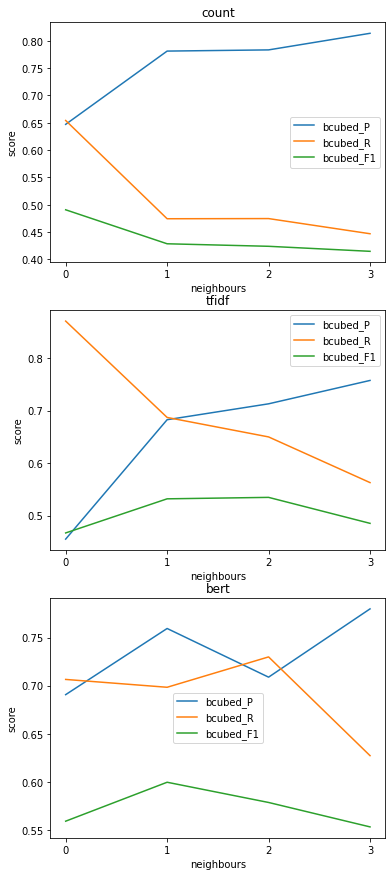

In [7]:
fig, ax = plt.subplots(3)
fig.set_figheight(15)
cwr = count_word_raw[count_word_raw['ngram_range'] == '(1, 3)'].drop(columns=['P','R','F1','max_features','ngram_range'])
ax[0].plot([0,1,2,3],cwr['bcubed_P'])
ax[0].plot([0,1,2,3],cwr['bcubed_R'])
ax[0].plot([0,1,2,3],cwr['bcubed_F1'])
ax[0].legend(['bcubed_P','bcubed_R','bcubed_F1'])
ax[0].set_xlabel('neighbours')
ax[0].set_ylabel('score')
ax[0].set_xticks([0,1,2,3])
ax[0].set_title('count')

twr = tfidf_word_raw[tfidf_word_raw['ngram_range'] == '(1, 3)'].drop(columns=['P','R','F1','max_features','ngram_range'])
ax[1].plot([0,1,2,3],twr['bcubed_P'])
ax[1].plot([0,1,2,3],twr['bcubed_R'])
ax[1].plot([0,1,2,3],twr['bcubed_F1'])
ax[1].legend(['bcubed_P','bcubed_R','bcubed_F1'])
ax[1].set_xlabel('neighbours')
ax[1].set_ylabel('score')
ax[1].set_xticks([0,1,2,3])
ax[1].set_title('tfidf')

bwr = bert_raw_neighbours
ax[2].plot([0,1,2,3],bwr['bcubed_R'])
ax[2].plot([0,1,2,3],bwr['bcubed_P'])
ax[2].plot([0,1,2,3],bwr['bcubed_F1'])
ax[2].legend(['bcubed_P','bcubed_R','bcubed_F1'])
ax[2].set_xlabel('neighbours')
ax[2].set_ylabel('score')
ax[2].set_xticks([0,1,2,3])
ax[2].set_title('bert')

In [8]:
a = tfidf_word_raw[tfidf_word_raw['ngram_range'] == '(1, 3)'].drop(columns=['P','R','F1','max_features','ngram_range']).copy()
a.iloc[0, 5]
twr['bcubed_P'].values

array([0.45521081, 0.68249461, 0.71274656, 0.75724538])

2. (Similarity) Voor de 'similarity' classifiers geldt, net als voor de 'raw' classifiers, dat naarmate meer buren toegevoegd worden, de bcubed Precision stijgt maar de bcubed Recall daalt. Dit is terug te zien voor iedere representatie. De F1 scores blijven overal ongeveer gelijk. Het toevoegen van meer buren heeft weinig tot geen invloed op overall performance.

Text(0.5, 1.0, 'bert')

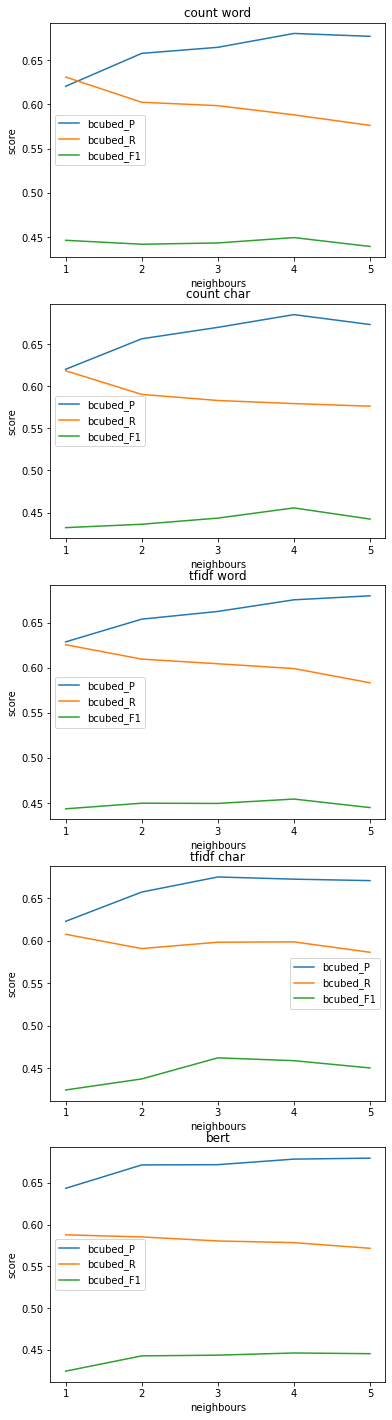

In [9]:
fig, ax = plt.subplots(5)
fig.set_figheight(25)
cws = count_word_sims[(count_word_sims['measure'] == 'cosine') & (count_word_sims['ngram_range'] == '(1, 3)') & (count_word_sims['max_features'] == 4096)]
ax[0].plot([1,2,3,4,5],cws['bcubed_P'])
ax[0].plot([1,2,3,4,5],cws['bcubed_R'])
ax[0].plot([1,2,3,4,5],cws['bcubed_F1'])
ax[0].legend(['bcubed_P','bcubed_R','bcubed_F1'])
ax[0].set_xlabel('neighbours')
ax[0].set_ylabel('score')
ax[0].set_xticks([1,2,3,4,5])
ax[0].set_title('count word')

ccs = count_char_sims[(count_char_sims['measure'] == 'cosine') & (count_char_sims['ngram_range'] == '(1, 3)') & (count_char_sims['max_features'] == 4096)]
ax[1].plot([1,2,3,4,5],ccs['bcubed_P'])
ax[1].plot([1,2,3,4,5],ccs['bcubed_R'])
ax[1].plot([1,2,3,4,5],ccs['bcubed_F1'])
ax[1].legend(['bcubed_P','bcubed_R','bcubed_F1'])
ax[1].set_xlabel('neighbours')
ax[1].set_ylabel('score')
ax[1].set_xticks([1,2,3,4,5])
ax[1].set_title('count char')

tws = tfidf_word_sims[(tfidf_word_sims['measure'] == 'cosine') & (tfidf_word_sims['ngram_range'] == '(1, 3)') & (tfidf_word_sims['max_features'] == 4096)]
ax[2].plot([1,2,3,4,5],tws['bcubed_P'])
ax[2].plot([1,2,3,4,5],tws['bcubed_R'])
ax[2].plot([1,2,3,4,5],tws['bcubed_F1'])
ax[2].legend(['bcubed_P','bcubed_R','bcubed_F1'])
ax[2].set_xlabel('neighbours')
ax[2].set_ylabel('score')
ax[2].set_xticks([1,2,3,4,5])
ax[2].set_title('tfidf word')

tcs = tfidf_char_sims[(tfidf_char_sims['measure'] == 'cosine') & (tfidf_char_sims['ngram_range'] == '(1, 3)') & (tfidf_char_sims['max_features'] == 4096)]
ax[3].plot([1,2,3,4,5],tcs['bcubed_P'])
ax[3].plot([1,2,3,4,5],tcs['bcubed_R'])
ax[3].plot([1,2,3,4,5],tcs['bcubed_F1'])
ax[3].legend(['bcubed_P','bcubed_R','bcubed_F1'])
ax[3].set_xlabel('neighbours')
ax[3].set_ylabel('score')
ax[3].set_xticks([1,2,3,4,5])
ax[3].set_title('tfidf char')

bs = bert_sims[(bert_sims['measure'] == 'cosine')]
ax[4].plot([1,2,3,4,5],bs['bcubed_P'])
ax[4].plot([1,2,3,4,5],bs['bcubed_R'])
ax[4].plot([1,2,3,4,5],bs['bcubed_F1'])
ax[4].legend(['bcubed_P','bcubed_R','bcubed_F1'])
ax[4].set_xlabel('neighbours')
ax[4].set_ylabel('score')
ax[4].set_xticks([1,2,3,4,5])
ax[4].set_title('bert')

### Results - Similarity classifiers

In [10]:
sim_df = count_word_sims[count_word_sims['ngram_range'].isin(['(1, 1)','(1, 2)','(1, 3)'])].append(count_char_sims).append(tfidf_word_sims).append(tfidf_char_sims).append(bert_sims).groupby(['type','model','analyzer','measure','neighbours']).max()[['bcubed_P','bcubed_R','bcubed_F1','P','R','F1']]
sim_df

bcubed_P  bcubed_R  bcubed_F1  \
type model analyzer measure neighbours                                  
sim  bert  bert     cosine  1           0.643563  0.587884   0.424449   
                            2           0.671639  0.585302   0.442766   
                            3           0.671936  0.580502   0.443608   
                            4           0.678603  0.578485   0.446225   
                            5           0.679767  0.571716   0.445399   
                    jaccard 1           0.001800  1.000000   0.003580   
                            2           0.001800  1.000000   0.003580   
                            3           0.034030  0.974878   0.040847   
                            4           0.040992  0.970818   0.049013   
                            5           0.063123  0.951352   0.068046   
     count char     cosine  1           0.636956  0.623172   0.434645   
                            2           0.678927  0.604055   0.451930   
                            3           0.679534  0.600447   0.452756   
                            4           0.685756  0.594343   0.458973   
                            5           0.693112  0.588290   0.464587   
                    jaccard 1           0.646167  0.963329   0.436547   
                            2           0.669671  0.763496   0.441426   
                            3           0.680368  0.647268   0.443698   
                            4           0.694586  0.593114   0.444847   
                            5           0.693872  0.577664   0.447068   
           word     cosine  1           0.627277  0.641299   0.452904   
                            2           0.657635  0.621027   0.442274   
                            3           0.666992  0.614438   0.443701   
                            4           0.682258  0.596173   0.449780   
                            5           0.676872  0.590957   0.445703   
                    jaccard 1           0.561267  0.709513   0.434128   
                            2           0.642492  0.634665   0.456967   
                            3           0.674466  0.602754   0.452926   
                            4           0.675926  0.593953   0.455085   
                            5           0.692681  0.574413   0.451176   
     tfidf char     cosine  1           0.635894  0.628949   0.438780   
                            2           0.673193  0.607771   0.452459   
                            3           0.687475  0.598942   0.462164   
                            4           0.689710  0.598524   0.458824   
                            5           0.694130  0.597269   0.456484   
                    jaccard 1           0.001800  1.000000   0.003580   
                            2           0.001800  1.000000   0.003580   
                            3           0.039276  0.991641   0.062492   
                            4           0.043018  0.990225   0.067009   
                            5           0.061732  0.986084   0.089497   
           word     cosine  1           0.629755  0.973938   0.448212   
                            2           0.665142  0.963147   0.459064   
                            3           0.672575  0.963099   0.452461   
                            4           0.675169  0.960772   0.454668   
                            5           0.683006  0.959100   0.453651   
                    jaccard 1           0.001800  1.000000   0.003580   
                            2           0.001800  1.000000   0.003580   
                            3           0.035791  1.000000   0.053277   
                            4           0.049208  1.000000   0.069844   
                            5           0.114710  0.980743   0.149918   

                                               P         R        F1  
type model analyzer measure neighbours                                
sim  bert  bert     cosine  1           0.295204  0.212315  0.246991  
                            2 